In [16]:
from carbon.helpers.stdimports import *
from carbon.helpers import j, strategy, pdread, pdcols, fsave, listdir, Params
from carbon.helpers.widgets import CheckboxManager, DropdownManager, PcSliderManager
from carbon.helpers.simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS

plt.rcParams['figure.figsize'] = [12,6]
plt_style('seaborn-v0_8-dark', 'seaborn-dark')
print_version(require="2.2.5")

Carbon v2.2.6 (28/Jan/2022)


# Carbon Simulation - Demo 7-3

_[frozen_20230128][frozen]: **this** notebook on [Binder][frozen_nb] and on [github][frozen_gh];  **latest** notebook on [Binder][latest_nb] and on [github][latest_gh]_

Use **Run -- Run All Cells** in the menu above to run the notebook, then adjust the simulation parameters as desired. Further resources are (1) the github repo [github:carbon-simulator-binder][repob] associated with this binder, (2) the main simulator repo [github:carbon-simulator][repo], (3) the carbon package [pypi:carbon-simulator][simpypi] and finally (4) the ["Carbon Simulator" presentation][presn]

[presn]:https://github.com/bancorprotocol/carbon-simulator/blob/beta/resources/notes/202301%20Simulating%20Carbon.pdf
[simpypi]:https://pypi.org/project/carbon-simulator/
[repo]:https://github.com/bancorprotocol/carbon-simulator
[repob]:https://github.com/bancorprotocol/carbon-simulator-binder
[frozen]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230128
[frozen_nb]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230128?labpath=Frozen%2FDemo7-3%2FDemo7-3.ipynb
[frozen_gh]:https://github.com/bancorprotocol/carbon-simulator-binder/blob/frozen_20230128/Frozen/Demo7-3/Demo7-3.ipynb
[latest_nb]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/latest_7_3?labpath=Frozen%2FDemo7-3%2FDemo7-3.ipynb
[latest_gh]:https://github.com/bancorprotocol/carbon-simulator-binder/blob/latest_7_3/Frozen/Demo7-3/Demo7-3.ipynb

## Setup

In [17]:
import datetime 
fname = lambda data, col, strat: f"{datetime.datetime.now().strftime('%m%d-%H%M%S')}-{data}-{col.replace('/', '')}-{strat}.png"

### Generated output

In [18]:
OUTPATH = "."                               # where to save generated charts (None to not save)
DELETE_BEFORE_SIM = True                    # if True, delete all output files before running a new Sim
print(f"OUTPATH = {OUTPATH}")

OUTPATH = .


### Path data

In [19]:
DATAID = "COINS-CROSS"

DATAPATH = "../data"
DATAFN = j(DATAPATH, f"{DATAID}.pickle")
print(f"DATAID = {DATAID}")

DATAID = COINS-CROSS


In [20]:
!ls {DATAPATH}/*.pickle

../data/COINS-BTC.pickle    ../data/COS.pickle
../data/COINS-CROSS.pickle  ../data/RAN-050-00.pickle
../data/COINS-ETH.pickle    ../data/RAN-SIGMU.pickle
../data/COINS-USD.pickle    ../data/STABLES-USD.pickle


In [21]:
", ".join(pdcols(DATAFN))

'ETH/LTC, ETH/OKB, DOT/MATIC, BNB/AVAX, ADA/SOL, BNB/TRX, DOGE/TRX, DOGE/BNB, LTC/ADA, SOL/ETH, ETH/SOL, BNB/LTC, BNB/OKB, SOL/XRP, BTC/MATIC, AVAX/DOGE, AVAX/ATOM, ETH/ADA, XRP/ETH, BNB/SOL, DOGE/SOL, SOL/AVAX, BNB/BTC, SOL/TRX, SOL/BNB, TRX/ETH, OKB/DOGE, OKB/ATOM, XRP/BTC, SOL/LTC, SOL/OKB, BNB/ADA, DOGE/ADA, ATOM/DOT, TRX/XRP, XRP/AVAX, TRX/BTC, XRP/TRX, XRP/BNB, ATOM/ETH, DOT/ETH, MATIC/DOT, TRX/AVAX, XRP/LTC, SOL/DOT, XRP/OKB, ADA/MATIC, TRX/BNB, ADA/ATOM, MATIC/ETH, AVAX/MATIC, AVAX/ETH, ATOM/XRP, LTC/DOGE, ATOM/BTC, DOT/XRP, TRX/LTC, TRX/OKB, DOT/BTC, BTC/DOT, ATOM/MATIC, MATIC/XRP, ATOM/AVAX, MATIC/BTC, ADA/DOGE, XRP/DOT, ATOM/TRX, ATOM/BNB, OKB/MATIC, OKB/ETH, SOL/BTC, BTC/ETH, DOT/AVAX, DOT/TRX, DOT/BNB, ETH/DOGE, ETH/ATOM, MATIC/AVAX, ATOM/LTC, TRX/DOT, ATOM/OKB, XRP/ADA, MATIC/BNB, MATIC/TRX, DOT/LTC, DOT/OKB, BTC/XRP, MATIC/LTC, MATIC/OKB, TRX/ADA, AVAX/LTC, AVAX/OKB, ATOM/SOL, BNB/DOGE, OKB/AVAX, BTC/AVAX, DOT/SOL, DOGE/ATOM, OKB/TRX, OKB/BNB, BTC/TRX, BTC/BNB, LTC/MATIC

In [22]:
COLS_INVERT = {
    "ETH/LTC"   : False,
    "ETH/OKB"   : False, 
    "DOT/MATIC" : False, 
    "BNB/AVAX"  : False
}
print(f"COLS_INVERT = {COLS_INVERT}")

COLS_INVERT = {'ETH/LTC': False, 'ETH/OKB': False, 'DOT/MATIC': False, 'BNB/AVAX': False}


### Simulation parameters

In [23]:
SIM_PARAMS = {
    'plotPrice': True,
    'plotValueCsh': False,
    'plotValueRsk': False,
    'plotValueTotal': True,
    'plotValueHODL': True,
    'plotRanges': True,
    'plotMargP': True,
    'plotBid': True,
    'plotAsk': True
}
print(f"SIM_PARAMS = {SIM_PARAMS}")

SIM_PARAMS = {'plotPrice': True, 'plotValueCsh': False, 'plotValueRsk': False, 'plotValueTotal': True, 'plotValueHODL': True, 'plotRanges': True, 'plotMargP': True, 'plotBid': True, 'plotAsk': True}


### Strategies 

In [24]:
STRATS = {
     "single":     strategy.from_mgw(m=100, g=0.01, w=0.02, amt_rsk=1, amt_csh=0),
     "multiple":   [strategy.from_mgw(m=100, g=0.25, w=0.05, amt_rsk=1, amt_csh=0),
                   strategy.from_mgw(m=100, g=0.10, w=0.03, amt_rsk=1, amt_csh=0)],  
     "univ3":      strategy.from_u3(p_lo=100, p_hi=150, start_below=True, fee_pc=0.05, tvl_csh=1000),
}
print(f"STRATS ids = {tuple(STRATS)}")

STRATS ids = ('single', 'multiple', 'univ3')


In [25]:
STARTPC = 0
LENPC = 1
PATH_MIN_DATE = "2022-01-01"

## Simulation

In [26]:
if DELETE_BEFORE_SIM:
    !rm {OUTPATH}/*.png
    !rm {OUTPATH}/_CHARTS.*

rm: cannot remove './_CHARTS.*': No such file or directory


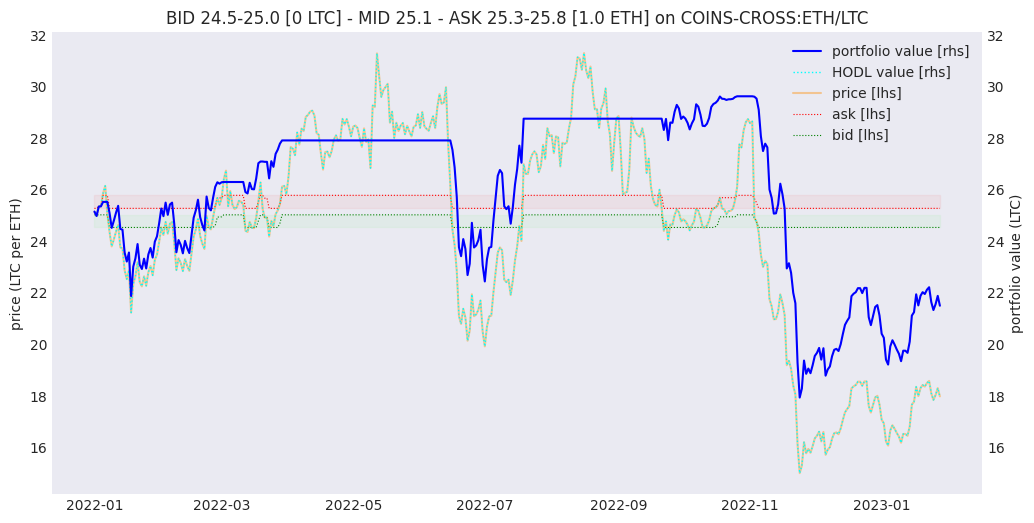

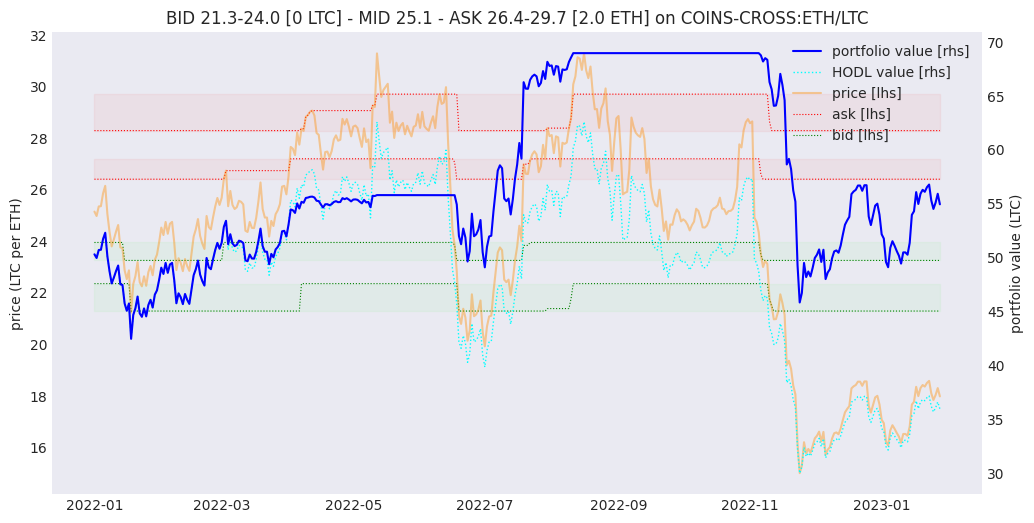

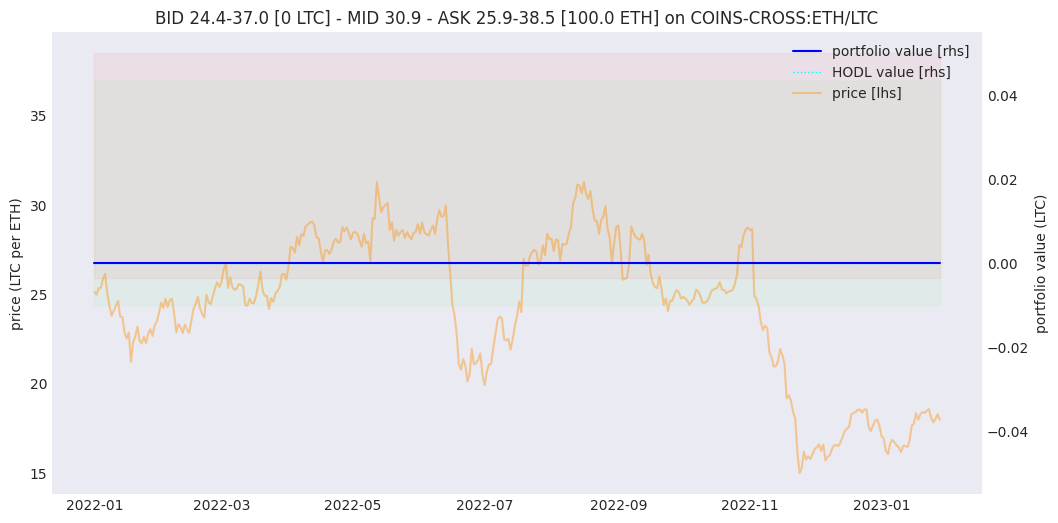

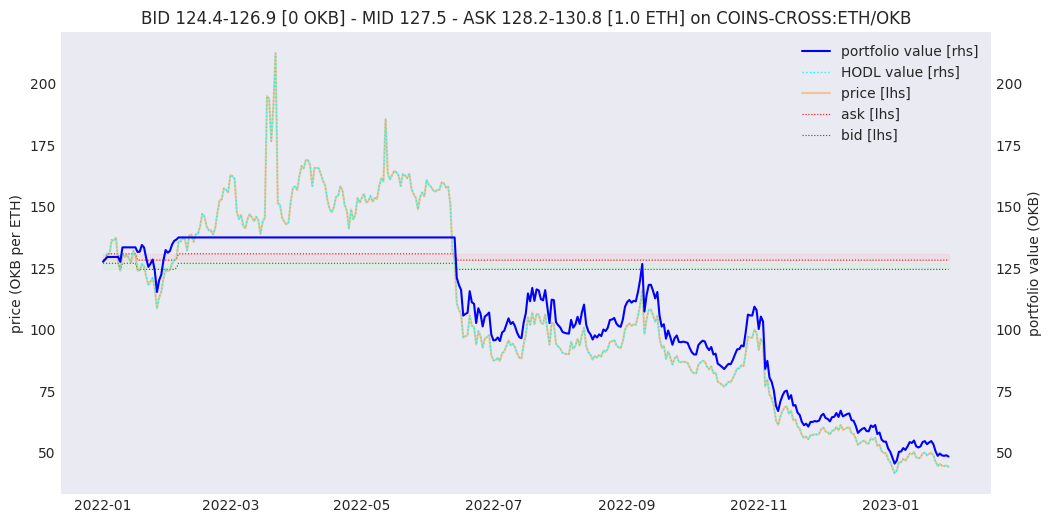

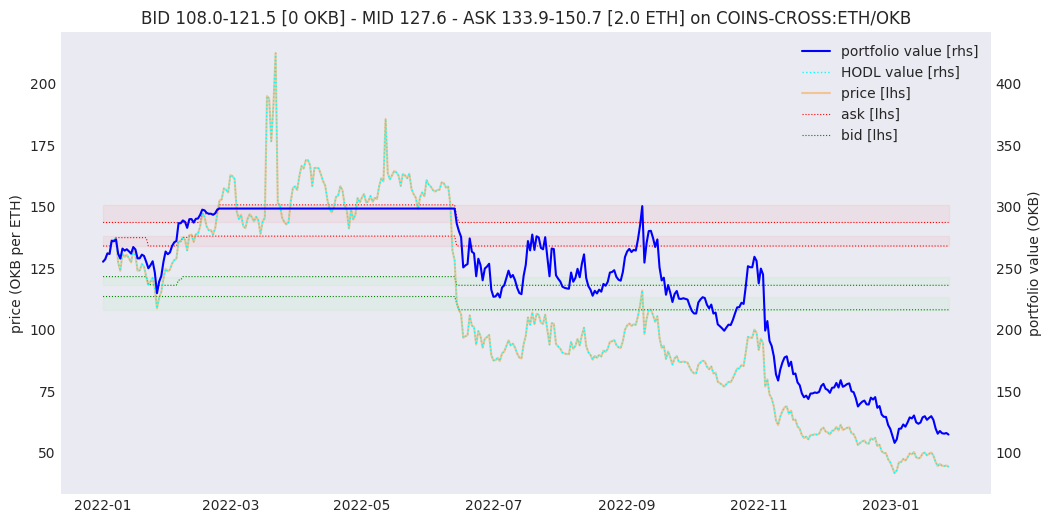

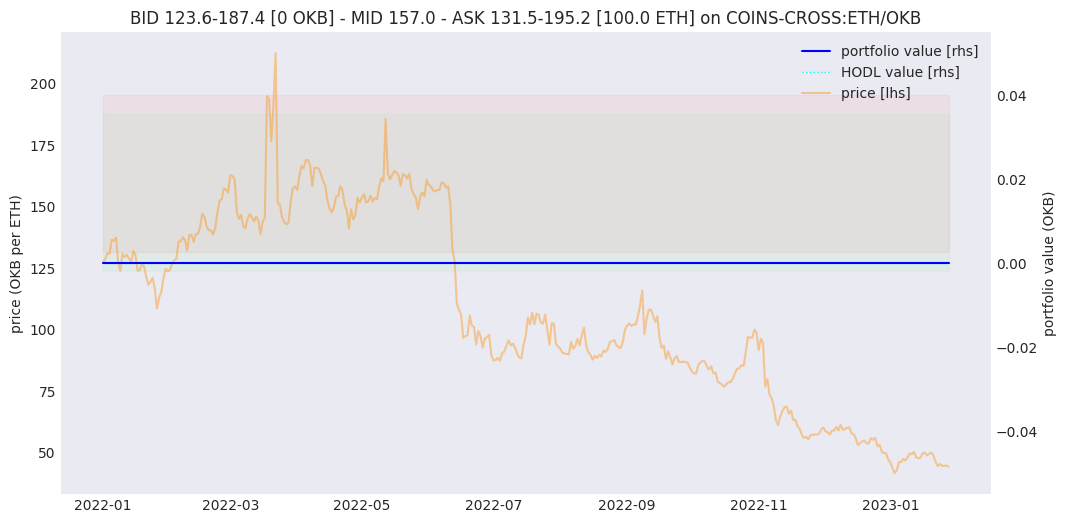

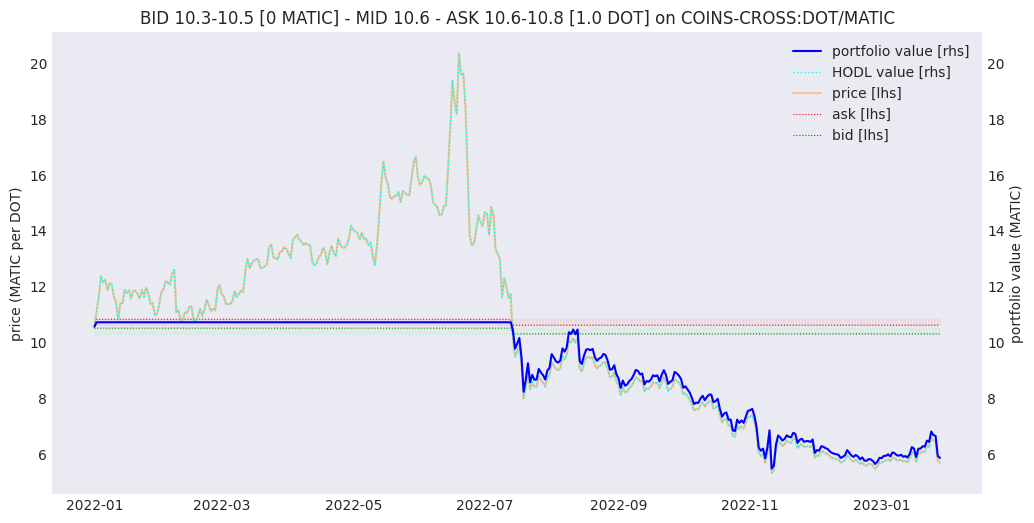

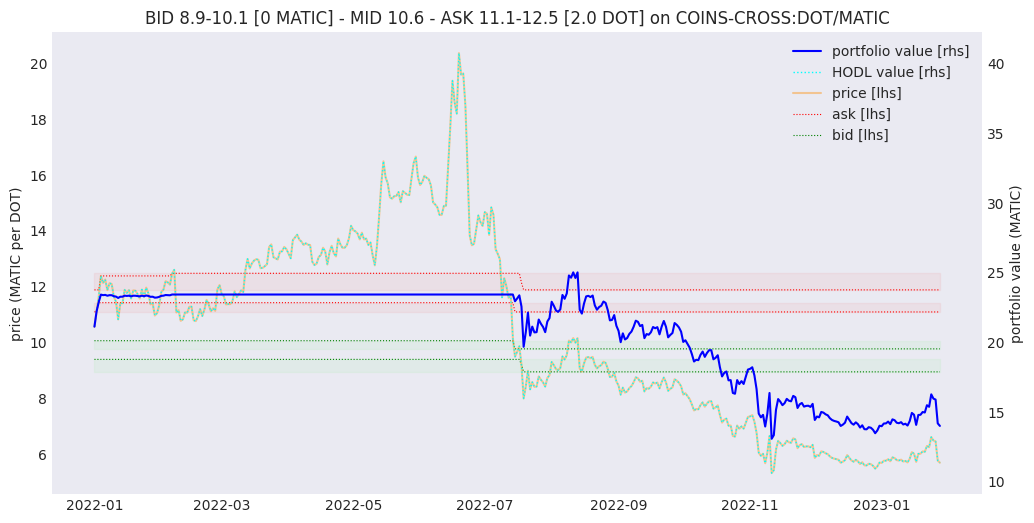

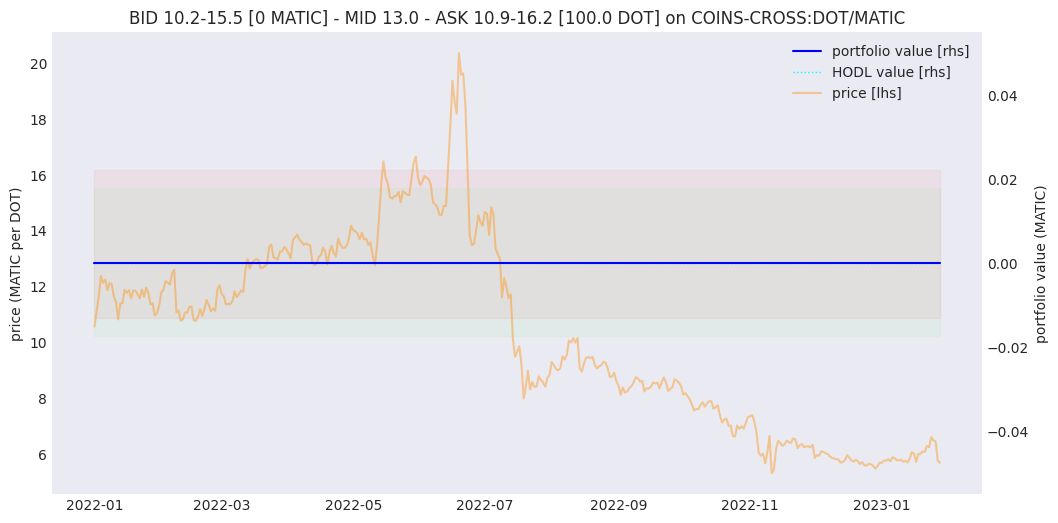

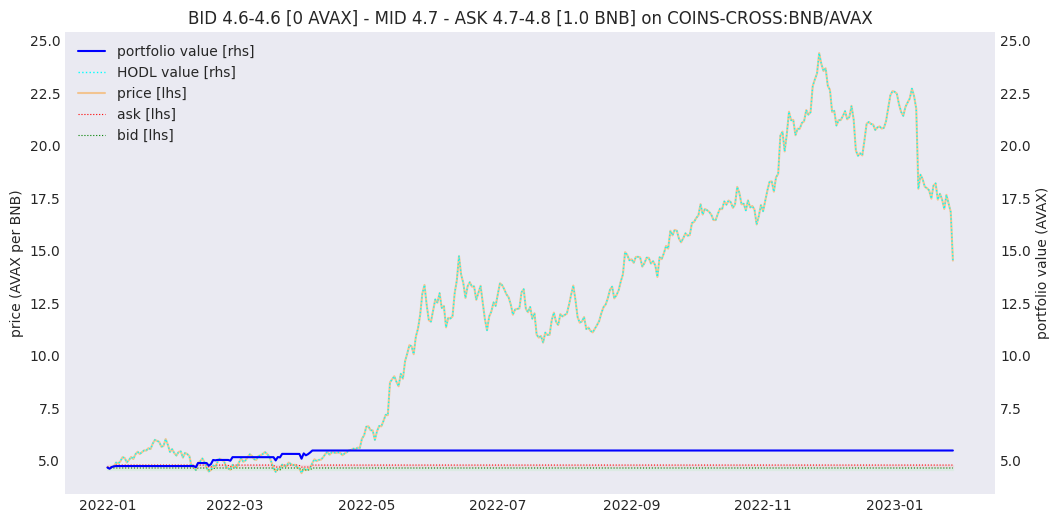

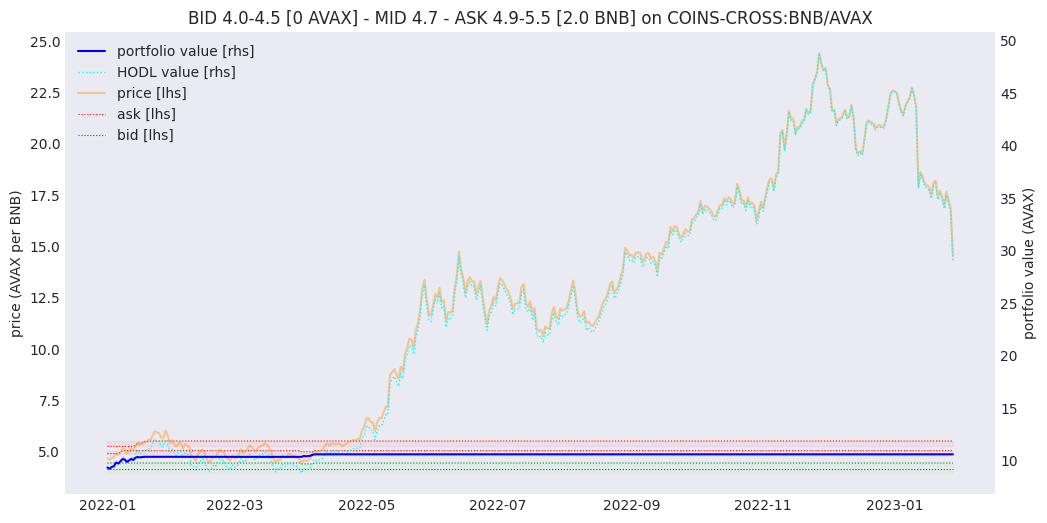

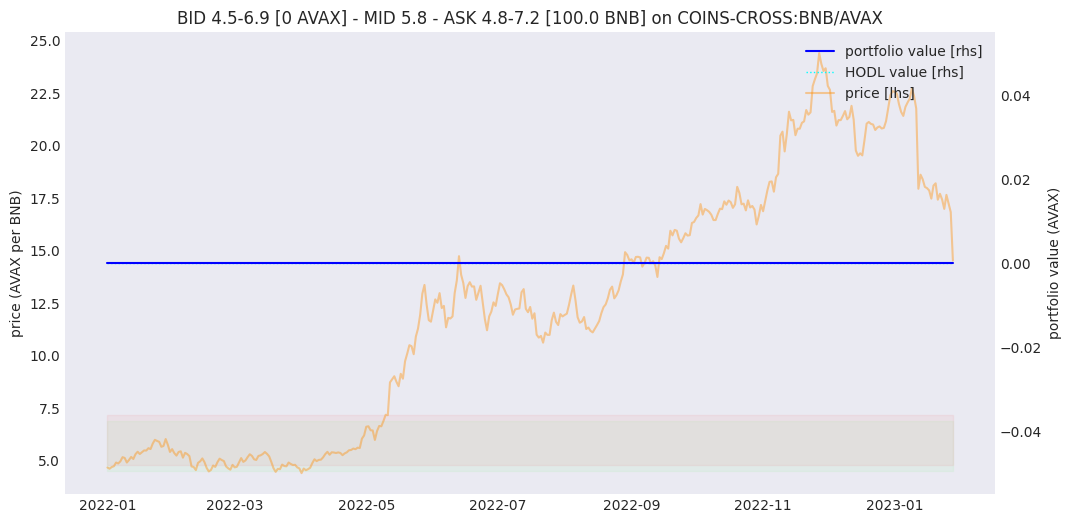

In [27]:
for colnm, invert in COLS_INVERT.items():
    path, pair = pdread(DATAFN, colnm, from_pc=STARTPC, period_pc=LENPC, min_dt=PATH_MIN_DATE, invert=invert, tkns=True)
    for stratid, strat in STRATS.items():
        simresults = run_sim(strat, path, shift=0)
        plot_sim(simresults, simresults, f"{DATAID}:{colnm}", Params(**SIM_PARAMS), pair=pair)
        if isinstance(OUTPATH, str):
            plt.savefig(j(OUTPATH, fname(DATAID, colnm, stratid)))
        plt.show()

In [28]:
if OUTPATH and False:
    print("Listing OUTPATH [uncheck box at top to disable]")
    print ("\n".join([fn[:-4] for fn in os.listdir(OUTPATH) if fn[-4:]==".png"]))

In [29]:
if OUTPATH:
    print("Creating consolidated docx and zip from charts [uncheck box at top to disable]")
    markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in [fn for fn in os.listdir(OUTPATH) if fn[-4:]==".png"])
    fsave(markdown, "_CHARTS.md", OUTPATH, quiet=True)
    !pandoc {OUTPATH}/_CHARTS.md -o {OUTPATH}/_CHARTS.docx
    !zip _CHARTS.zip -qq *.png 

Creating consolidated docx and zip from charts [uncheck box at top to disable]
